In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
plt.style.use('./Plotstyle/deeplearning.mplstyle')

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

#### Context
- Cardiovascular disease (CVDs) is the number one cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of five CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs.

#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [3]:
# Load the dataset using pandas
df = pd.read_csv("Datasets/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### One Hot Encoding for the Categorical Values

In [10]:
cat_classes = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [11]:
df = pd.get_dummies(df,
                    columns=cat_classes,
                    prefix=cat_classes)

In [15]:
## Removing our target variable
features = [x for x in df.columns if x not in 'HeartDisease'] 

In [16]:
len(features)

20

### Split the Dataset

In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(df[features], df['HeartDisease'], train_size=0.8, random_state=RANDOM_STATE)

In [18]:
print(f"Training Samples: {len(X_train)}")
print(f"Validation Samples: {len(X_val)}")
print(f"Target Proportion: {sum(Y_train)/len(Y_train):.4f}")

Training Samples: 734
Validation Samples: 184
Target Proportion: 0.5518


# Building Models

## 1. Decision Trees
The hyperparameters we will use and investigate here are:

 - min_samples_split: The minimum number of samples required to split an internal node. 
   - Choosing a higher min_samples_split can reduce the number of splits and may help to reduce overfitting.
 - max_depth: The maximum depth of the tree. 
   - Choosing a lower max_depth can reduce the number of splits and may help to reduce overfitting.

In [21]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

### Training with Minimum Samples Split Parameter

In [22]:
accuracy_list_train = []
accuracy_list_val = []

In [23]:
for min_samples_split in min_samples_split_list:
    model = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=RANDOM_STATE).fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    accuracy_train = accuracy_score(prediction_train, Y_train)
    accuracy_val = accuracy_score(prediction_val, Y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

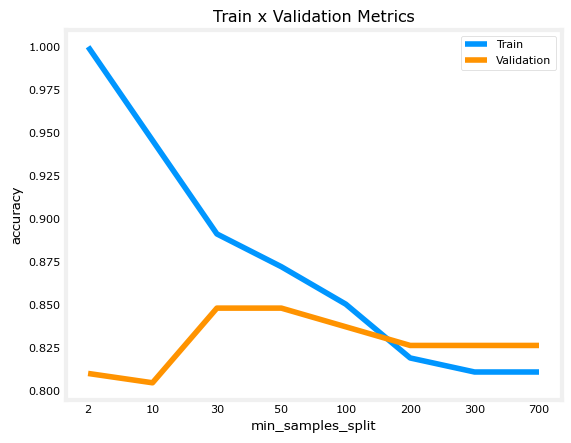

In [24]:
plt.title("Train x Validation Metrics")
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

Note how increasing the the number of `min_samples_split` reduces overfitting.
- Increasing `min_samples_split` from 10 to 30, and from 30 to 50, even though it does not improve the validation accuracy, it brings the training accuracy closer to it, showing a reduction in overfitting.

### Training with Maximum Depth Parameter

In [25]:
accuracy_list_train = []
accuracy_list_val = []

In [28]:
for max_depth in max_depth_list:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=RANDOM_STATE).fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    accuracy_train = accuracy_score(prediction_train, Y_train)
    accuracy_val = accuracy_score(prediction_val, Y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

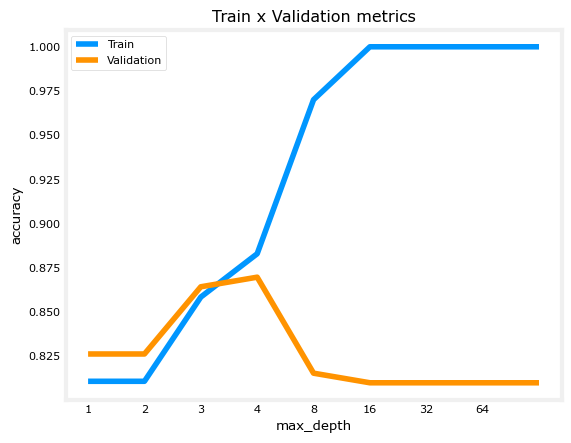

In [29]:
plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list)), labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

### Conclusion

- Reducing `max_depth` from 8 to 4 increases validation accuracy closer to training accuracy, while significantly reducing training accuracy.
- The validation accuracy reaches the highest at tree_depth=4. 
- When the `max_depth` is smaller than 3, both training and validation accuracy decreases.  The tree cannot make enough splits to distinguish positives from negatives (the model is underfitting the training set). 
- When the `max_depth` is too high ( >= 5), validation accuracy decreases while training accuracy increases, indicating that the model is overfitting to the training set.

So we can choose the best values for these two hyper-parameters for our model to be:
- `max_depth = 4`
- `min_samples_split = 50` 

In [30]:
decision_tree_model = DecisionTreeClassifier(max_depth=4, min_samples_split=50, random_state=RANDOM_STATE).fit(X_train, Y_train)

In [33]:
print(f"Matrics Train:\n\tAccuracy Score:{accuracy_score(decision_tree_model.predict(X_train),Y_train):.4f}")
print(f"Matrics Validation:\n\tAccuracy Score:{accuracy_score(decision_tree_model.predict(X_val),Y_val):.4f}")

Matrics Train:
	Accuracy Score:0.8665
Matrics Validation:
	Accuracy Score:0.8696


## 2. Random Forest
All of the hyperparameters found in the decision tree model will also exist in this algorithm, since a random forest is an ensemble of many Decision Trees.
- One additional hyperparameter for Random Forest is called `n_estimators` which is the number of Decision Trees that make up the Random Forest.

Remember that for a Random Forest, we randomly choose a subset of the features AND randomly choose a subset of the training examples to train each individual tree.
- Following the lectures, if $n$ is the number of features, we will randomly select $\sqrt{n}$ of these features to train each individual tree. 
- Note that you can modify this by setting the `max_features` parameter.

You can also speed up your training jobs with another parameter, `n_jobs`. 
- Since the fitting of each tree is independent of each other, it is possible fit more than one tree in parallel. 
- So setting `n_jobs` higher will increase how many CPU cores it will use. Note that the numbers very close to the maximum cores of your CPU may impact on the overall performance of your PC and even lead to freezes. 
- Changing this parameter does not impact on the final result but can reduce the training time.

We will run the same script again, but with another parameter, `n_estimators`, where we will choose between 10, 50, and 100. The default is 100.

In [50]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,                                      ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

### Training with Minimum Samples Split

In [51]:
accuracy_list_train = []
accuracy_list_val = []

In [52]:
for min_samples_split in min_samples_split_list:
    model = RandomForestClassifier(min_samples_split=min_samples_split, random_state=RANDOM_STATE).fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    accuracy_train = accuracy_score(prediction_train, Y_train)
    accuracy_val = accuracy_score(prediction_val, Y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

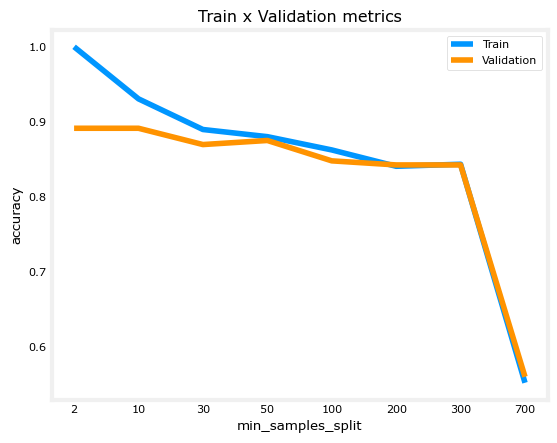

In [53]:
plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

### Training with Maximum Depth Parameter

In [59]:
accuracy_list_train = []
accuracy_list_val = []

In [60]:
for max_depth in max_depth_list:
    model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_STATE).fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    accuracy_train = accuracy_score(prediction_train, Y_train)
    accuracy_val = accuracy_score(prediction_val, Y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

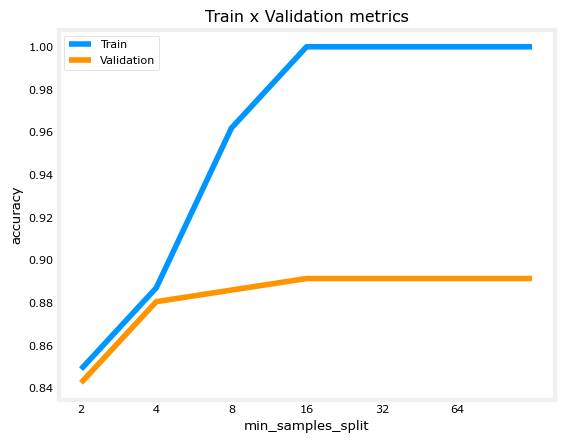

In [61]:
plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list)),labels=max_depth_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

### Training with N Estimators Parameter

In [62]:
accuracy_list_train = []
accuracy_list_val = []

In [63]:
for n_estimators in n_estimators_list:
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=RANDOM_STATE).fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    accuracy_train = accuracy_score(prediction_train, Y_train)
    accuracy_val = accuracy_score(prediction_val, Y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

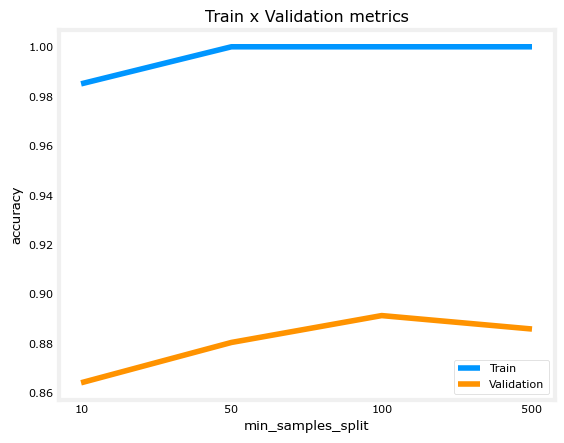

In [64]:
plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list)),labels=n_estimators_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

### Conclusion

Random forest with the following parameters:
 - max_depth: 16
 - min_samples_split: 10
 - n_estimators: 100

In [65]:
random_forest_model = RandomForestClassifier(max_depth=16, min_samples_split=10, n_estimators=100, random_state=RANDOM_STATE).fit(X_train, Y_train)

In [66]:
print(f"Metrics Training:\n\tAccuracy Score: {accuracy_score(random_forest_model.predict(X_train), Y_train)}")
print(f"Metrics Validation:\n\tAccuracy Score: {accuracy_score(random_forest_model.predict(X_val), Y_val)}")

Metrics Training:
	Accuracy Score: 0.9305177111716622
Metrics Validation:
	Accuracy Score: 0.8913043478260869


- Ideally, we would want to check every combination of values for every hyperparameter that we are tuning.
- If we have 3 hyperparameters, and each hyperparameter has 4 values to try out, we should have a total of 4 x 4 x 4 = 64 combinations to try.
- When we only modify one hyperparameter while leaving the rest as their default value, we are trying 4 + 4 + 4 = 12 results. 
- To try out all combinations, we can use a sklearn implementation called GridSearchCV. GridSearchCV has a refit parameter that will automatically refit a model on the best combination so we will not need to program it explicitly. For more on GridSearchCV, please refer to its [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

## 3. XGBoost
The model has the same parameters as a decision tree, plus the learning rate.
- The learning rate is the size of the step on the Gradient Descent method that the XGBoost uses internally to minimize the error on each train step.

One interesting thing about the XGBoost is that during fitting, it can take in an evaluation dataset of the form `(X_val,y_val)`.
- On each iteration, it measures the cost (or evaluation metric) on the evaluation datasets.
- Once the cost (or metric) stops decreasing for a number of rounds (called early_stopping_rounds), the training will stop. 
- More iterations lead to more estimators, and more estimators can result in overfitting.  
- By stopping once the validation metric no longer improves, we can limit the number of estimators created, and reduce overfitting.

In [68]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval

In [71]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], Y_train[:n], Y_train[n:]

some of the `.fit()` parameters:
- `eval_set = [(X_train_eval,y_train_eval)]`:Here we must pass a list to the eval_set, because you can have several different tuples ov eval sets. 
- `early_stopping_rounds`: This parameter helps to stop the model training if its evaluation metric is no longer improving on the validation set. It's set to 10.

In [76]:
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.1, verbosity=1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval, y_train_eval)], early_stopping_rounds=10)

c:\Users\IKOICHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.63302
[1]	validation_0-logloss:0.59554
[2]	validation_0-logloss:0.56614
[3]	validation_0-logloss:0.54187
[4]	validation_0-logloss:0.52349
[5]	validation_0-logloss:0.50611
[6]	validation_0-logloss:0.49373
[7]	validation_0-logloss:0.48366
[8]	validation_0-logloss:0.47323
[9]	validation_0-logloss:0.46538
[10]	validation_0-logloss:0.46000
[11]	validation_0-logloss:0.45621


[12]	validation_0-logloss:0.45483
[13]	validation_0-logloss:0.44975
[14]	validation_0-logloss:0.44495
[15]	validation_0-logloss:0.44073
[16]	validation_0-logloss:0.44078
[17]	validation_0-logloss:0.43936
[18]	validation_0-logloss:0.44206
[19]	validation_0-logloss:0.44536
[20]	validation_0-logloss:0.44322
[21]	validation_0-logloss:0.44310
[22]	validation_0-logloss:0.44419
[23]	validation_0-logloss:0.44797
[24]	validation_0-logloss:0.44843
[25]	validation_0-logloss:0.45337
[26]	validation_0-logloss:0.45206
[27]	validation_0-logloss:0.45435


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=55, ...)

In [77]:
xgb_model.best_iteration

17

In [79]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),Y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),Y_val):.4f}")

Metrics train:
	Accuracy score: 0.9319
Metrics test:
	Accuracy score: 0.8533
